# Importazione librerie

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import Metriche_di_performance as mdp
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
from itertools import product
import numpy as np
import ccxt
import time

# Lettura dati Bitcoin

In [139]:
# def download_and_plot(exchange_name, cryptos, timeframe, start_date, end_date, plot):
    
#     exchange = getattr(ccxt, exchange_name)()  # Usa Bybit come exchange
#     exchange.load_markets()  # Carica i mercati disponibili
#     cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

#     # Converti date in timestamp
#     start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
#     end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

#     data_frames = {}

#     for pair in cryptos_pairs:
#         if pair not in exchange.markets:
#             raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

#         print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
#         ohlcv = []
#         since = start_timestamp

#         # Scarica i dati in blocchi fino a raggiungere la data di fine
#         while since < end_timestamp:
#             batch = exchange.fetch_ohlcv(pair, timeframe, since)
#             if not batch:
#                 break
#             ohlcv.extend(batch)
#             since = batch[-1][0] + 1  # Avanza al prossimo blocco
#             time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

#         # Crea un DataFrame dai dati
#         df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
#         df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
#         df.set_index('timestamp', inplace=True)

#         # Filtra i dati oltre la data di fine
#         df = df[df.index <= pd.Timestamp(end_date)]
#         data_frames[pair] = df

#         if plot:
#             # Plot dei dati
#             plt.figure(figsize=(14, 8))

#             # Grafico della prima crypto
#             plt.subplot(3, 1, 1)
#             plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
#             plt.title(f"{pair} Price")
#             plt.ylabel('Price (USDT)')
#             plt.grid()
#             plt.legend()

#             plt.tight_layout()
#             plt.show()

#     return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [140]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [141]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2021-02-01'
data_fine = '2021-07-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


In [142]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
# data_inizio = '2021-02-01'
# data_fine = '2021-07-01'

In [143]:
# exchange_name = 'bybit'
# chosen_cryptos = ['BTC']
# timeframe_download = '1d'

# data_frames = download_and_plot(exchange_name, chosen_cryptos, timeframe_download, data_inizio, data_fine, plot=False)

# # Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
# crypto_prices = pd.DataFrame()
# crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
# for crypto in chosen_cryptos:
#     crypto_prices[crypto] = data_frames[crypto]['close'].values

In [144]:
# dati = crypto_prices.rename(columns={'timestamp': 'Timestamp', 'BTC': 'Price'})
# dati

In [145]:
# dati.isna().sum().sum()

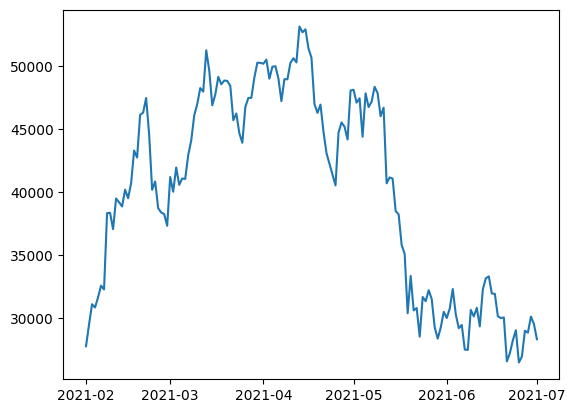

In [146]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia 1

In [147]:
# Funzioni di supporto
def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
    return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

def quanto_acquistare(A_a, B_a, variazione_perc, perc_primo_acquisto, liquidità_attuale, max_liquidità):
    if variazione_perc == 0:
        return min(max_liquidità * perc_primo_acquisto, liquidità_attuale)
    elif variazione_perc < 0:
        return min(max_liquidità * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a), liquidità_attuale)
    print('Errore! Non può essere maggiore di 0 la variazione tra un acquisto e il successivo')

def quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin, max_bitcoin):
    if variazione_vendite_inversa == 0:
        return min(max_bitcoin * perc_prima_vendita, bitcoin)
    elif variazione_vendite_inversa < 0:
        return min(max_bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v), bitcoin)
    print('Errore! Non può essere maggiore di 0 la variazione inversa tra una vendita e la successiva')

In [148]:
def trading_doppio_TS(
    dati, 
    liquidità_iniziale, 
    bitcoin_iniziali, 
    perc_primo_acquisto,
    perc_prima_vendita,
    perc_TS, 
    perc_TS_inverso_setting,
    A_a,
    B_a,
    A_v,
    B_v
):

    # Dati iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_TS = dati['Price'].iloc[0]
    prezzo_TS_inverso = dati['Price'].iloc[0]
    prezzo_minimo = dati['Price'].iloc[0]
    prezzo_max_ciclo = dati['Price'].iloc[0]

    # Variabili di supporto
    prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
    quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
    valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
    in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
    ultima_azione = "-"
    flag = False
    n_vendite_ciclo = 0
    max_liquidità = -np.inf
    max_bitcoin = -np.inf

    # Lista per registrare le transazioni
    transazioni = []

    # Itera sui dati
    for _, row in dati.iterrows():
        prezzo = row["Price"]
        timestamp = row["Timestamp"]
        azione = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0
        if liquidità > max_liquidità:
            max_liquidità = liquidità
        if bitcoin > max_bitcoin:
            max_bitcoin = bitcoin

        # Aggiorna il prezzo minimo nella scia corrente
        if in_scia_acquisti:
            if prezzo_minimo is None or prezzo < prezzo_minimo:
                prezzo_minimo = prezzo
                prezzo_TS_inverso = min(
                    prezzo * (1 + perc_TS_inverso_setting),
                    prezzo_medio_acquisti
                )

        # Controlla se l'acquisto è un "primo acquisto"
        if (ultima_azione == "Vendita" or ultima_azione == "-") and liquidità > 0:
            # Primo acquisto
            quantità_acquisto = min(perc_primo_acquisto * max_liquidità, liquidità) / prezzo
            liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
            liquidità -= liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = quantità_acquisto
            bitcoin += bitcoin_comprati_o_venduti
            prezzo_medio_acquisti = prezzo
            valore_totale_acquisti = liquidità_spesa_o_guadagnata
            quantità_acquisti = quantità_acquisto
            prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
            prezzo_minimo = prezzo
            prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
            in_scia_acquisti = True
            ultima_azione = "Acquisto"
            azione = "Acquisto"
            prezzo_primo_acquisto = prezzo
            prezzo_precedente_acquisto = prezzo
            # n_acquisti_scia += 1
            n_vendite_ciclo = 0
            prezzo_max_ciclo = 0

        elif in_scia_acquisti and liquidità > 0:
            # Controlla se effettuare un acquisto in scia
            if prezzo < prezzo_medio_acquisti:
                if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso and prezzo < prezzo_precedente_acquisto: # direi che è superfluo chiedersi se prezzo < prezzo_TS perchè dovrebbe essere ovvio se prezzo < prezzo_medio_acquisti
                    # Acquisto in scia
                    variazione_acquisti = (prezzo - prezzo_primo_acquisto) / prezzo_primo_acquisto
                    quantità_acquisto = quanto_acquistare(A_a, B_a, variazione_acquisti, perc_primo_acquisto, max_liquidità, liquidità) / prezzo
                    liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
                    liquidità -= liquidità_spesa_o_guadagnata
                    bitcoin_comprati_o_venduti = quantità_acquisto
                    bitcoin += bitcoin_comprati_o_venduti
                    valore_totale_acquisti += liquidità_spesa_o_guadagnata
                    quantità_acquisti += quantità_acquisto
                    prezzo_medio_acquisti = (prezzo_medio_acquisti * (valore_totale_acquisti - liquidità_spesa_o_guadagnata) + prezzo * liquidità_spesa_o_guadagnata) / valore_totale_acquisti
                    prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS) # aggiorno prezzo_TS per aver acquistato
                    azione = "Acquisto"
                    prezzo_precedente_acquisto = prezzo
                    # n_acquisti_scia += 1

        # Controlla se effettuare una vendita
        if prezzo_TS is not None and prezzo > prezzo_TS:
            if flag: # aggiorno prezzo_TS per aver superato prezzo_TS, ma solo se è appena successo
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                flag = False
            if prezzo > prezzo_max_ciclo:
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                prezzo_max_ciclo = prezzo
            else:
                pass
        elif prezzo_TS is not None and prezzo < prezzo_TS and not flag: # se il prezzo è già salito oltre prezzo_TS e ora è tornato sotto quel livello
            # Vendita
            if n_vendite_ciclo == 0:
                prezzo_prima_vendita = prezzo
            variazione_vendite_inversa = (prezzo_prima_vendita - prezzo) / prezzo
            quantità_vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, max_bitcoin, bitcoin)
            liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
            liquidità += liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = -quantità_vendita
            bitcoin += bitcoin_comprati_o_venduti
            azione = "Vendita"
            prezzo_TS = None
            prezzo_TS_inverso = None
            prezzo_minimo = None
            prezzo_medio_acquisti = 0
            quantità_acquisti = 0
            valore_totale_acquisti = 0
            in_scia_acquisti = False
            ultima_azione = "Vendita"
            flag = True
            n_vendite_ciclo += 1
            # n_acquisti_scia = 0

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + bitcoin * prezzo

        # Registra la transazione
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "prezzo_medio_acquisti_scia": prezzo_medio_acquisti,
            "prezzo_TS": prezzo_TS,
            "prezzo_TS_inverso": prezzo_TS_inverso,
            "ultima_azione": ultima_azione,
            "azione": azione,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
            "liquidità_posseduta": liquidità,
            "bitcoin": bitcoin,
            "valore_totale_portafoglio": valore_totale_portafoglio,
        })

    # Converti la lista di transazioni in un dataframe
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [149]:
liquidità_iniziale=0
bitcoin_iniziali=0.02478146
perc_primo_acquisto=0.5
perc_prima_vendita=0.5
perc_TS=0.08
perc_TS_inverso_setting=0.05
A_a = 0.1
B_a = 0.15
A_v = 0.1
B_v = 0.15

df_transazioni = trading_doppio_TS(
    dati=dati,
    liquidità_iniziale=liquidità_iniziale,
    bitcoin_iniziali=bitcoin_iniziali,
    perc_primo_acquisto=perc_primo_acquisto,
    perc_prima_vendita=perc_prima_vendita,
    perc_TS=perc_TS,
    perc_TS_inverso_setting=perc_TS_inverso_setting,
    A_a = A_a,
    B_a = B_a,
    A_v = A_v,
    B_v = B_v
)

df_transazioni

,timestamp,prezzo,prezzo_medio_acquisti_scia,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin,valore_totale_portafoglio
0,2021-02-01,27790.582031,0.000000,27790.582031,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,688.691197
1,2021-02-02,29501.521484,0.000000,29364.646328,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,731.090775
2,2021-02-03,31119.447266,0.000000,30979.063191,27790.582031,-,-,0.000000,0.000000,0.000000e+00,0.024781,771.185338
3,2021-02-04,30859.554688,0.000000,NaN,NaN,Vendita,Vendita,382.372410,-0.012391,3.823724e+02,0.012391,764.744820
4,2021-02-05,31658.248047,31658.248047,34190.907891,31658.248047,Acquisto,Acquisto,191.186205,0.006039,1.911862e+02,0.018430,774.641214
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,49328.588173,53274.875227,27827.983887,Acquisto,-,0.000000,0.000000,3.970800e-17,0.021662,628.508810
147,2021-06-28,28866.302734,49328.588173,53274.875227,27827.983887,Acquisto,-,0.000000,0.000000,3.970800e-17,0.021662,625.314910
148,2021-06-29,30139.980469,49328.588173,53274.875227,27827.983887,Acquisto,-,0.000000,0.000000,3.970800e-17,0.021662,652.905893
149,2021-06-30,29555.054688,49328.588173,53274.875227,27827.983887,Acquisto,-,0.000000,0.000000,3.970800e-17,0.021662,640.234966


In [150]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.8914656330320448)

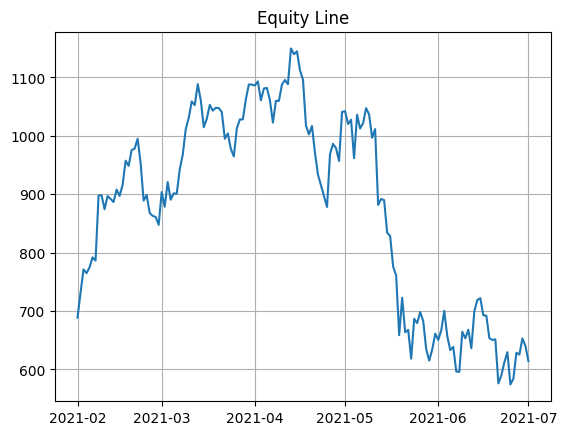

In [151]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [152]:
mdp.calcola_principali_metriche(df_transazioni['valore_totale_portafoglio'], df_transazioni['prezzo'], df_transazioni['bitcoin'])

{'Total Return': np.float64(-10.85343669679552),
 'Max Drawdown': 50.05360484811294,
 'Volatility': np.float64(0.693433522552381),
 'Sharpe Ratio': np.float64(0.06888348852332986),
 'Sortino Ratio': np.float64(0.11543774280921054),
 'Calmar Ratio': np.float64(-0.21683626443550152),
 'Profit Factor': inf,
 'PnL': np.float64(68.70092263249612)}

In [153]:
df_transazioni[:50]

,timestamp,prezzo,prezzo_medio_acquisti_scia,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin,valore_totale_portafoglio
0,2021-02-01,27790.582031,0.000000,27790.582031,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,688.691197
1,2021-02-02,29501.521484,0.000000,29364.646328,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,731.090775
2,2021-02-03,31119.447266,0.000000,30979.063191,27790.582031,-,-,0.000000,0.000000,0.000000,0.024781,771.185338
3,2021-02-04,30859.554688,0.000000,NaN,NaN,Vendita,Vendita,382.372410,-0.012391,382.372410,0.012391,764.744820
4,2021-02-05,31658.248047,31658.248047,34190.907891,31658.248047,Acquisto,Acquisto,191.186205,0.006039,191.186205,0.018430,774.641214
5,2021-02-06,32588.472656,31658.248047,34190.907891,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,791.785062
6,2021-02-07,32288.650391,31658.248047,34190.907891,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,786.259400
7,2021-02-08,38329.667969,31658.248047,38303.179904,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,897.594113
8,2021-02-09,38362.296875,31658.248047,38357.567517,31658.248047,Acquisto,-,0.000000,0.000000,191.186205,0.018430,898.195457
9,2021-02-10,37065.046875,0.000000,NaN,NaN,Vendita,Vendita,341.550600,-0.009215,532.736805,0.009215,874.287406


In [154]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [155]:
crea_grafico_transazioni(df_transazioni)

### Grafico interattivo temporale

In [156]:
# Funzione per calcolare la dimensione dei pallini
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Aggiungi colonne necessarie per dimensioni pallini
max_quantita_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['liquidità_spesa_o_guadagnata'].max()
max_quantita_acquisto = df_transazioni[df_transazioni['azione'] == 'Acquisto']['liquidità_spesa_o_guadagnata'].max()

df_transazioni['dimensioni_vendite'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_vendita)
    if row['azione'] == 'Vendita' else 0, axis=1
)
df_transazioni['dimensioni_acquisti'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_acquisto)
    if row['azione'] == 'Acquisto' else 0, axis=1
)

# App Dash
app = dash.Dash(__name__)

# Layout Dash
app.layout = html.Div([
    html.H1("Grafico Interattivo delle Transazioni"),
    dcc.Graph(id='grafico-transazioni'),
    dcc.Slider(
        id='slider-giorno',
        min=0,
        max=len(df_transazioni) - 1,
        value=0,
        marks={i: str(df_transazioni['timestamp'].iloc[i].date()) for i in range(0, len(df_transazioni), 10)},
        step=1
    ),
    html.Div([
        html.Button("Giorno precedente", id='btn-prev', n_clicks=0),
        html.Button("Giorno successivo", id='btn-next', n_clicks=0),
    ], style={'marginTop': '20px', 'display': 'flex', 'gap': '10px'})
])

# Callback per aggiornare il grafico in base al giorno selezionato
@app.callback(
    Output('grafico-transazioni', 'figure'),
    Input('slider-giorno', 'value')
)
def aggiorna_grafico(giorno):
    # Filtra i dati fino al giorno corrente
    dati_fino_a_giorno = df_transazioni.iloc[:giorno + 1]
    dati_giorno_corrente = df_transazioni.iloc[giorno:giorno + 1]

    # Linea dei prezzi
    trace_prezzo = go.Scatter(
        x=dati_fino_a_giorno['timestamp'],
        y=dati_fino_a_giorno['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2)
    )

    # Pallini per le vendite
    vendite = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Vendita']
    trace_vendite = go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=vendite['dimensioni_vendite'], opacity=0.7)
    )

    # Pallini per gli acquisti
    acquisti = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Acquisto']
    trace_acquisti = go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=acquisti['dimensioni_acquisti'], opacity=0.7)
    )

    # Linea orizzontale per prezzo_TS del giorno corrente
    trace_TS = None
    if pd.notna(dati_giorno_corrente['prezzo_TS'].iloc[0]):
        trace_TS = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS',
            line=dict(color='purple', dash='dash')
        )

    # Linea orizzontale per prezzo_TS_inverso del giorno corrente
    trace_TS_inverso = None
    if pd.notna(dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]):
        trace_TS_inverso = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS_inverso',
            line=dict(color='orange', dash='dash')
        )

    # Crea la figura
    figure = go.Figure(data=[trace_prezzo, trace_vendite, trace_acquisti])
    if trace_TS:
        figure.add_trace(trace_TS)
    if trace_TS_inverso:
        figure.add_trace(trace_TS_inverso)

    # Configurazione layout
    figure.update_layout(
        title='Grafico Interattivo delle Transazioni',
        xaxis_title=f"Date fino al {dati_giorno_corrente['timestamp'].iloc[0]}",
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white'
    )

    return figure

# Callback per gestire i pulsanti
@app.callback(
    Output('slider-giorno', 'value'),
    [Input('btn-prev', 'n_clicks'),
     Input('btn-next', 'n_clicks')],
    State('slider-giorno', 'value')
)
def aggiorna_slider(btn_prev, btn_next, slider_value):
    ctx = dash.callback_context

    if not ctx.triggered:
        return slider_value

    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'btn-prev':
        return max(slider_value - 1, 0)
    elif trigger_id == 'btn-next':
        return min(slider_value + 1, len(df_transazioni) - 1)

    return slider_value

# Avvia l'app Dash
if __name__ == '__main__':
    app.run_server(debug=True)

# Grid search

In [ ]:
def grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali):
    """
    Esegue una grid search sulla funzione strategia_vendita per ottimizzare i parametri variabili.
    
    Parameters:
    - param_grid (dict): Dizionario in cui le chiavi sono i nomi dei parametri e i valori sono liste di valori da testare.
    - dati (pd.DataFrame): DataFrame con i dati storici dei prezzi.
    - liquidità_iniziale (float): Liquidità iniziale in euro.
    - bitcoin_iniziali (float): Quantità iniziale di Bitcoin posseduti.
    
    Returns:
    - dict: Risultato con la miglior combinazione e il miglior fattore di rendimento.
    """
    # Genera tutte le combinazioni di parametri
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))
    n_combinations = len(all_combinations)
    
    # Variabili per tracciare il miglior risultato
    miglior_fattore_rendimento = 0
    miglior_iterazione = None
    miglior_combinazione = None

    # Loop attraverso tutte le combinazioni
    for i, values in enumerate(all_combinations, start=1):
        # Crea un dizionario con la combinazione corrente di parametri
        params = dict(zip(param_names, values))
        
        if not condizioni_salto[i-1]:
            # Esegui la strategia con i parametri correnti
            df_transazioni = trading_doppio_TS(
                dati, liquidità_iniziale, bitcoin_iniziali, **params
            )

            # Calcola il fattore di rendimento
            portafoglio_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
            portafoglio_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'].iloc[0]
            fattore_rendimento = portafoglio_finale / portafoglio_iniziale

            # Aggiorna il miglior risultato se il rendimento corrente è superiore
            if fattore_rendimento > miglior_fattore_rendimento:
                miglior_fattore_rendimento = fattore_rendimento
                miglior_iterazione = i
                miglior_combinazione = params

            # Stampa dei risultati dell'iterazione corrente
            print(f"Iterazione {i}/{n_combinations}")
            print(f"  Combinazione testata: {', '.join(f'{k}={v}' for k, v in params.items())}")
            print(f"  Fattore di rendimento: {fattore_rendimento:.4f}")
            print(f"  Miglior fattore di rendimento finora: {miglior_fattore_rendimento:.4f} "
                f"(Iterazione {miglior_iterazione}, Combinazione: {', '.join(f'{k}={v}' for k, v in miglior_combinazione.items())})")
            print("\n")
        else:
            print(f"Saltata combinazione {', '.join(f'{k}={v}' for k, v in params.items())} perchè sarebbe uguale a una già testata\n")

    # Ritorna il miglior risultato
    return {
        "miglior_fattore_rendimento": miglior_fattore_rendimento,
        "miglior_iterazione": miglior_iterazione,
        "miglior_combinazione": miglior_combinazione
    }

In [ ]:
# Esempio di definizione dei parametri per la grid search
param_grid = {
    "perc_primo_acquisto": [0, 0.0005, 0.005, 0.05, 0.5, 1],
    "perc_prima_vendita": [0.108, 0.26, 1],
    "perc_TS": [0, 0.02, 0.036, 0.1],
    "perc_TS_inverso_setting": [0, 0.022, 0.1],
    "A_a": [0, 0.001, 0.01, 2.51],
    "B_a": [0, 1, 3.88, 5],
    "A_v": [0.01, 0.72, 3, 10],
    "B_v":[0, 2.25, 5, 10]
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
all_combinations = list(product(*param_values))
n_combinations = len(all_combinations)

condizioni_salto = []
# Loop attraverso tutte le combinazioni
for i, values in enumerate(all_combinations, start=1):
    # Crea un dizionario con la combinazione corrente di parametri
    params = dict(zip(param_names, values))
    condizione = False
    condizioni_salto.append(condizione)

# Esecuzione della grid search
risultato = grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali)

# Stampa del miglior risultato
print("Risultato della Grid Search:")
print(f"  Miglior fattore di rendimento: {risultato['miglior_fattore_rendimento']}")
print(f"  Trovato all'iterazione: {risultato['miglior_iterazione']}")
print(f"  Combinazione di parametri ottimale: {', '.join(f'{k}={v}' for k, v in risultato['miglior_combinazione'].items())}")

# 1.6035

# Strategia 2

In [21]:
def simulate_trailing_strategy(data, trailing_buy, trailing_stop, stop_loss_pct, second_stop_loss_pct, perc_commission_buy, perc_commission_sell, initial_cash, initial_bitcoin, min_buy, min_sell):
    """
    Simula una strategia di trailing stop e trailing buy su un DataFrame contenente i prezzi di bitcoin.

    Args:
        data (pd.DataFrame): DataFrame con almeno due colonne: 'Timestamp' e 'Price'.
        trailing_buy (float): Percentuale di trailing buy (esempio: 0.01 per 1%).
        trailing_stop (float): Percentuale di trailing stop (esempio: 0.02 per 2%).
        stop_loss_pct (float): Percentuale del primo stop loss dopo l'acquisto.
        second_stop_loss_pct (float): Percentuale del secondo stop loss.
        perc_commission_buy (float): Percentuale di commissione sull'acquisto (esempio: 0.001 per 0.1%).
        perc_commission_sell (float): Percentuale di commissione sulla vendita (esempio: 0.001 per 0.1%).
        initial_cash (float): Liquidità iniziale (in USDT).
        initial_bitcoin (float): Quantità iniziale di bitcoin.
        min_buy (float): Prezzo minimo di acquisto in USDT.
        min_sell (float): Prezzo minimo di vendita in USDT.

    Returns:
        pd.DataFrame: DataFrame delle transazioni giornaliere con dettagli.
    """
    # Variabili di supporto
    cash = initial_cash
    bitcoin = initial_bitcoin
    trailing_buy_price = None
    trailing_stop_price = None
    buy_price = None
    lowest_price_since_buy = None # Per gestire il trailing buy
    second_stop_loss = None # Secondo stop loss
    last_action = None # Ultima azione effettiva: "Acquisto" o "Vendita"
    liquidità_spesa_o_guadagnata = 0
    bitcoin_comprati_o_venduti = 0

    transactions = []  # Lista per registrare le transazioni giornaliere

    for i, row in data.iterrows():
        price = row['Price']
        timestamp = row['Timestamp']

        # Effettua eventuali operazioni di acquisto o vendita
        action = "-"  # Azione del giorno, "-" se nessuna azione

        if last_action is None or last_action == "Vendita":
            # Modalità trailing buy
            if trailing_buy_price is None:
                lowest_price_since_buy = price
                trailing_buy_price = price * (1 + trailing_buy)

            lowest_price_since_buy = min(lowest_price_since_buy, price)
            trailing_buy_price = lowest_price_since_buy * (1 + trailing_buy)

            distance_to_trailing = -(price - trailing_buy_price) / trailing_buy_price

            if price >= trailing_buy_price and cash >= min_buy:
                # Effettua l'acquisto
                bitcoin_bought = cash / price * (1 - perc_commission_buy)
                buy_price = price
                trailing_stop_price = buy_price * (1 - trailing_stop)
                stop_loss_price = buy_price * (1 - stop_loss_pct)
                second_stop_loss = None # Verrà impostato solo se il prezzo supererà buy_price / (1 - perc_commission_buy)
                liquidità_spesa_o_guadagnata = cash
                cash = 0
                bitcoin += bitcoin_bought
                last_action = "Acquisto"
                action = "Acquisto"
                bitcoin_comprati_o_venduti = bitcoin_bought

        elif last_action == "Acquisto":
            # Modalità trailing stop
            if price > buy_price / (1 - perc_commission_buy) and second_stop_loss is None:
                second_stop_loss = buy_price / (1 - perc_commission_buy) * (1 - second_stop_loss_pct) + price * second_stop_loss_pct

            if price > trailing_stop_price:
                trailing_stop_price = max(trailing_stop_price or 0, price * (1 - trailing_stop))

            distance_to_trailing = -(price - trailing_stop_price) / trailing_stop_price

            # Controlla se il prezzo scende sotto il massimo tra i livelli di stop
            stop_limit = max(stop_loss_price, trailing_stop_price, second_stop_loss or 0)
            if price <= stop_limit and bitcoin * price >= min_sell:
                # Effettua la vendita
                sell_price = price
                cash += bitcoin * sell_price * (1 - perc_commission_sell)
                bitcoin_comprati_o_venduti = bitcoin
                bitcoin = 0
                last_action = "Vendita"
                if price <= trailing_stop_price:
                    action = "Vendita trailing stop"
                elif not second_stop_loss is None and price <= second_stop_loss:
                    action = 'Vendita second stop loss'
                elif price <= stop_loss_price:
                    action = 'Vendita first stop loss'
                liquidità_spesa_o_guadagnata = cash

                # Resetta variabili dopo la vendita
                trailing_buy_price = None
                trailing_stop_price = None
                buy_price = None
                second_stop_loss = None

        else:
            # Nessuna azione effettuata, calcola la distanza per completezza
            distance_to_trailing = 0

        # Calcola il valore del portafoglio alla fine della giornata
        portfolio_value = cash + bitcoin * price

        # Registra la riga giornaliera
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action or "-",
            "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
            "distance_to_trailing": distance_to_trailing, 'liquidità_spesa_o_guadagnata': liquidità_spesa_o_guadagnata, 'bitcoin_comprati_o_venduti': bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin, "valore_totale_portafoglio": portfolio_value
        })

    # Crea un DataFrame dalle transazioni
    transactions_df = pd.DataFrame(transactions)
    return transactions_df

In [52]:
# Esempio di utilizzo
trailing_buy = 0.02
trailing_stop = 0.02
stop_loss_pct = 0.001
second_stop_loss_pct = 0.01
perc_commission_buy = 0.001 # 0.1% commissione acquisto
perc_commission_sell = 0.001 # 0.1% commissione vendita
initial_cash = 10
initial_bitcoin = 0
min_buy_price = 1 # Prezzo minimo di acquisto
min_sell_price = 1 # Prezzo minimo di vendita

df_transazioni = simulate_trailing_strategy(dati, trailing_buy, trailing_stop, stop_loss_pct, second_stop_loss_pct,
                                             perc_commission_buy, perc_commission_sell, initial_cash, initial_bitcoin,
                                             min_buy_price, min_sell_price)
df_transazioni

,timestamp,prezzo,azione,ultima_azione,trailing_buy_price,trailing_stop_price,distance_to_trailing,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-01 00:00:00,32546.27,-,-,33197.1954,NaN,0.019608,0.000000,0.000000,10.000000,0.000000,10.000000
1,2021-02-01 01:00:00,33430.29,Acquisto,Acquisto,33197.1954,32761.6842,-0.007022,10.000000,0.000299,0.000000,0.000299,9.990000
2,2021-02-01 02:00:00,33649.73,-,Acquisto,33197.1954,32976.7354,-0.020408,10.000000,0.000299,0.000000,0.000299,10.055575
3,2021-02-01 03:00:00,33573.97,-,Acquisto,33197.1954,32976.7354,-0.018111,10.000000,0.000299,0.000000,0.000299,10.032936
4,2021-02-01 04:00:00,33558.25,-,Acquisto,33197.1954,32976.7354,-0.017634,10.000000,0.000299,0.000000,0.000299,10.028238
...,...,...,...,...,...,...,...,...,...,...,...,...
3589,2021-06-30 20:00:00,34580.40,-,Vendita,35272.0080,NaN,0.019608,10.029439,0.000289,10.029439,0.000000,10.029439
3590,2021-06-30 21:00:00,34806.16,-,Vendita,35272.0080,NaN,0.013207,10.029439,0.000289,10.029439,0.000000,10.029439
3591,2021-06-30 22:00:00,34892.37,-,Vendita,35272.0080,NaN,0.010763,10.029439,0.000289,10.029439,0.000000,10.029439
3592,2021-06-30 23:00:00,35045.00,-,Vendita,35272.0080,NaN,0.006436,10.029439,0.000289,10.029439,0.000000,10.029439


In [53]:
df_transazioni['azione'].value_counts()

azione
-                           3224
Acquisto                     185
Vendita first stop loss       79
Vendita trailing stop         53
Vendita second stop loss      53
Name: count, dtype: int64

In [54]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.0029439233771562)

In [55]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[(df_transazioni['azione'] == 'Vendita first stop loss') | (df_transazioni['azione'] == 'Vendita second stop loss') | (df_transazioni['azione'] == 'Vendita trailing stop')]
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [56]:
crea_grafico_transazioni_2(df_transazioni)

# Strategia 3

In [ ]:
# Funzione per determinare quanto acquistare
def quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash):
    variazione_primo = abs((price - first_buy_price) / first_buy_price)
    return min(ultimo_acquisto_speso + variazione_primo * cash, cash)

In [56]:
def simulate_trailing_strategy(data, trailing_buy_pct, trailing_stop_pct, stop_loss_pct, second_stop_loss_pct, perc_commission_buy, perc_commission_sell, first_buy_pct, initial_cash, initial_bitcoin, min_buy_price, min_sell_price):
    """
    Simula una strategia di trailing stop e trailing buy su un DataFrame contenente i prezzi di bitcoin.

    Args:
        data (pd.DataFrame): DataFrame con almeno due colonne: 'Timestamp' e 'Price'.
        trailing_buy (float): Percentuale di trailing buy (esempio: 0.01 per 1%).
        trailing_stop_pct (float): Percentuale di trailing stop (esempio: 0.02 per 2%).
        stop_loss_pct (float): Percentuale del primo stop loss dopo ogni acquisto.
        second_stop_loss_pct (float): Percentuale del secondo stop loss.
        perc_commission_buy (float): Percentuale di commissione sull'acquisto (esempio: 0.001 per 0.1%).
        perc_commission_sell (float): Percentuale di commissione sulla vendita (esempio: 0.001 per 0.1%).
        first_buy_pct (float): Percentuale della liquidità da usare per il primo acquisto di ogni ciclo.
        initial_cash (float): Liquidità iniziale (in USDT).
        initial_bitcoin (float): Quantità iniziale di bitcoin.
        min_buy_price (float): Prezzo minimo di acquisto in USDT.
        min_sell_price (float): Prezzo minimo di vendita in USDT.

    Returns:
        pd.DataFrame: DataFrame delle transazioni giornaliere con dettagli.
    """
    # Variabili di supporto
    cash = initial_cash
    bitcoin = initial_bitcoin
    trailing_buy_price = None
    trailing_stop_price = None
    fake_stop_loss_price = None
    second_stop_loss = None
    prezzo_medio_pesato_acquisti = None
    ultimo_acquisto_speso = 0  # Liquidità spesa per l'ultimo acquisto
    spesa_totale = 0
    first_buy_price = None
    last_action = None  # Ultima azione effettiva: "Acquisto" o "Vendita"

    transactions = []  # Lista per registrare le transazioni giornaliere

    for i, row in data.iterrows():
        price = row['Price']
        timestamp = row['Timestamp']

        # Variabili per liquidità spesa o guadagnata e bitcoin comprati o venduti
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Azione del giorno, "-" se nessuna azione
        action = "-"

        if last_action is None or last_action == "Vendita":
            # Modalità trailing buy
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + trailing_buy_pct)

            if price >= trailing_buy_price and cash * first_buy_pct >= min_buy_price:
                # Effettua il primo acquisto del ciclo
                liquidità_da_usare = cash * first_buy_pct
                bitcoin_bought = liquidità_da_usare / price * (1 - perc_commission_buy)
                bitcoin += bitcoin_bought
                liquidità_spesa_o_guadagnata = liquidità_da_usare
                cash -= liquidità_da_usare
                prezzo_medio_pesato_acquisti = price
                ultimo_acquisto_speso = liquidità_da_usare
                spesa_totale = liquidità_da_usare
                first_buy_price = price
                fake_stop_loss_price = price * (1 - stop_loss_pct)
                # trailing_stop_price = price * (1 - trailing_stop_pct)
                second_stop_loss = None
                last_action = "Acquisto"
                action = "Primo acquisto"

        elif last_action == "Acquisto":
            # Aggiornamenti legati al secondo stop loss e trailing stop
            if price > prezzo_medio_pesato_acquisti / (1 - perc_commission_buy):
                second_stop_loss = ((1 - second_stop_loss_pct) * prezzo_medio_pesato_acquisti / (1 - perc_commission_buy) + second_stop_loss_pct * price)
                trailing_stop_price = price * (1 - trailing_stop_pct)

            # Controlla il primo stop loss
            if price <= fake_stop_loss_price:
                liquidità_da_usare = quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash)
                if liquidità_da_usare >= min_buy_price:
                    bitcoin_bought = liquidità_da_usare / price * (1 - perc_commission_buy)
                    bitcoin += bitcoin_bought
                    liquidità_spesa_o_guadagnata = liquidità_da_usare
                    cash -= liquidità_da_usare
                    spesa_totale += liquidità_da_usare
                    prezzo_medio_pesato_acquisti = (prezzo_medio_pesato_acquisti * (spesa_totale - liquidità_da_usare) + price * liquidità_da_usare) / spesa_totale
                    ultimo_acquisto_speso = liquidità_da_usare
                    fake_stop_loss_price = price * (1 - stop_loss_pct)
                    action = "Acquisto"

            # Controlla il secondo stop loss o il trailing stop per vendere
            elif (price <= second_stop_loss or price <= trailing_stop_price) and bitcoin * price >= min_sell_price:
                liquidità_spesa_o_guadagnata = bitcoin * price * (1 - perc_commission_sell)
                cash += liquidità_spesa_o_guadagnata
                bitcoin_comprati_o_venduti = bitcoin
                bitcoin = 0
                last_action = "Vendita"
                action = "Vendita"
                trailing_buy_price = None
                fake_stop_loss_price = None
                trailing_stop_price = None
                second_stop_loss = None

        # Calcola il valore del portafoglio alla fine della giornata
        portfolio_value = cash + bitcoin * price

        # Registra la riga giornaliera
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action or "-",
            "Trailing_buy_Price": trailing_buy_price, "Trailing_Stop_Price": trailing_stop_price,
            "Fake_Stop_Loss_Price": fake_stop_loss_price, "Second_Stop_Loss": second_stop_loss,
            "Prezzo_Medio_Pesato_Acquisti": prezzo_medio_pesato_acquisti, "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Crea un DataFrame dalle transazioni
    transactions_df = pd.DataFrame(transactions)
    return transactions_df

In [57]:
# Esempio di utilizzo
trailing_buy_pct = 0.02
trailing_stop_pct = 0.02
stop_loss_pct = 0.05
second_stop_loss_pct = 0.01
perc_commission_buy = 0.001 # 0.1% commissione acquisto
perc_commission_sell = 0.001 # 0.1% commissione vendita
first_buy_pct = 0.01
initial_cash = 100
initial_bitcoin = 0
min_buy_price = 1 # Prezzo minimo di acquisto
min_sell_price = 1 # Prezzo minimo di vendita

df_transazioni = simulate_trailing_strategy(dati, trailing_buy_pct, trailing_stop_pct, stop_loss_pct, second_stop_loss_pct,
                                             perc_commission_buy, perc_commission_sell, first_buy_pct, initial_cash, initial_bitcoin,
                                             min_buy_price, min_sell_price)
df_transazioni

,timestamp,prezzo,azione,ultima_azione,Trailing_buy_Price,Trailing_Stop_Price,Fake_Stop_Loss_Price,Second_Stop_Loss,Prezzo_Medio_Pesato_Acquisti,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-01,27790.582031,-,-,28346.393672,NaN,NaN,NaN,NaN,0.0,0.0,100.000000,0.000000,100.000000
1,2021-02-02,29501.521484,Primo acquisto,Acquisto,28346.393672,NaN,28026.44541,NaN,29501.521484,1.0,0.0,99.000000,0.000034,99.999000
2,2021-02-03,31119.447266,-,Acquisto,28346.393672,30497.058320,28026.44541,29546.936484,29501.521484,0.0,0.0,99.000000,0.000034,100.053787
3,2021-02-04,30859.554688,-,Acquisto,28346.393672,30242.363594,28026.44541,29544.337558,29501.521484,0.0,0.0,99.000000,0.000034,100.044987
4,2021-02-05,31658.248047,-,Acquisto,28346.393672,31025.083086,28026.44541,29552.324492,29501.521484,0.0,0.0,99.000000,0.000034,100.072032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,-,Vendita,31277.817891,NaN,NaN,NaN,27546.242480,0.0,0.0,99.629814,0.000000,99.629814
147,2021-06-28,28866.302734,-,Vendita,31277.817891,NaN,NaN,NaN,27546.242480,0.0,0.0,99.629814,0.000000,99.629814
148,2021-06-29,30139.980469,-,Vendita,31277.817891,NaN,NaN,NaN,27546.242480,0.0,0.0,99.629814,0.000000,99.629814
149,2021-06-30,29555.054688,-,Vendita,31277.817891,NaN,NaN,NaN,27546.242480,0.0,0.0,99.629814,0.000000,99.629814


In [58]:
df_transazioni['azione'].value_counts()

azione
-                 148
Primo acquisto      1
Acquisto            1
Vendita             1
Name: count, dtype: int64

In [59]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9962981436231505)

In [60]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [61]:
crea_grafico_transazioni_2(df_transazioni)

# Strategia 4 (acquisti dal secondo in poi con fake_stop_loss)

In [ ]:
def mappatura_variazione_acquisti(variazione_perc, A_a, B_a):
    return variazione_perc ** A_a / (B_a + (1 - B_a) * variazione_perc ** A_a)

# Funzione per determinare quanto acquistare
def quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a):
    variazione_primo = abs((price - first_buy_price) / first_buy_price)
    variazione_mappata = mappatura_variazione_acquisti(variazione_primo, A_a, B_a)
    if do_buy:
        return min(last_buy_purchase + variazione_mappata * cash, cash)
    elif last_buy_purchase + variazione_mappata * cash > cash:
        return 0
    else:
        return last_buy_purchase + variazione_mappata * cash

In [202]:
def trading_doppio_TS_4(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
                              trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a):
    # Variabili iniziali
    cash = initial_cash
    bitcoin = initial_bitcoin
    last_action = None
    prezzo_medio_pesato_acquisti = 0
    spesa_totale = 0
    trailing_buy_price = None
    fake_stop_loss_price = None
    trailing_stop_price = None
    transactions = []

    for idx, row in dati.iterrows():
        timestamp = row['Timestamp']
        price = row['Price']
        action = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0
        
        # Se l'ultima azione è None o Vendita, dobbiamo impostare un trailing buy per iniziare un nuovo ciclo
        if last_action in [None, "Vendita"]:
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + trailing_buy_pct)
            else:
                trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))
            if price >= trailing_buy_price:
                # Acquista con la percentuale first_buy_pct della liquidità disponibile
                spesa = cash * first_buy_pct
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    cash -= spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = price
                    spesa_totale = spesa
                    first_buy_price = price
                    last_buy_purchase = spesa
                    fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
                    # trailing_buy_price = None
                    action = "Primo acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
                    last_action = "Acquisto"
        
        # Se l'ultima azione è Acquisto, valuta ulteriori acquisti o vendi
        elif last_action == "Acquisto":
            if price <= fake_stop_loss_price:
                # Acquisto successivo se il prezzo scende sotto il fake_stop_loss
                spesa = quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a)
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    cash -= spesa
                    last_buy_purchase = spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = (
                        prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
                    ) / (spesa_totale + spesa)
                    spesa_totale += spesa
                    fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
                    action = "Acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
            elif price > prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - trailing_sell_pct)):
                # Imposta un trailing sell
                if trailing_stop_price is None:
                    trailing_stop_price = price * (1 - trailing_sell_pct)
                else:
                    trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_sell_pct))
                if price <= trailing_stop_price:
                    # Vendi tutti i bitcoin posseduti
                    ricavato = bitcoin * price * (1 - commission_sell_pct)
                    if ricavato >= min_sell:
                        cash += ricavato
                        liquidità_spesa_o_guadagnata = ricavato
                        bitcoin_comprati_o_venduti = bitcoin
                        bitcoin = 0
                        spesa_totale = 0
                        prezzo_medio_pesato_acquisti = 0
                        trailing_buy_price = None
                        trailing_stop_price = None
                        fake_stop_loss_price = None
                        action = "Vendita"
                        last_action = "Vendita"

        # Valore totale del portafoglio
        portfolio_value = cash + bitcoin * price

        # Aggiungi la transazione
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
            "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
            "fake_stop_loss_price": fake_stop_loss_price, "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Restituisci il dataframe delle transazioni
    return pd.DataFrame(transactions)

In [203]:
initial_cash = 1000
initial_bitcoin = 0
commission_buy_pct = 0.001 # 0.1% commissione acquisto
commission_sell_pct = 0.001 # 0.1% commissione vendita
min_buy = 5 # Prezzo minimo di acquisto
min_sell = 5 # Prezzo minimo di vendita
trailing_buy_pct = 0.01
first_buy_pct = 0.01
fake_stop_loss_pct = 0.01
trailing_sell_pct = 0.001
do_buy = True # Sarebbe il compra_pure, che se è True e l'acquisto è superiore alla liquidità disponibile, usa tutta la liquidità, altrimenti non fa niente
A_a = 10
B_a = 10

df_transazioni = trading_doppio_TS_4(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
                              trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a)
df_transazioni

,timestamp,prezzo,azione,ultima_azione,trailing_buy_price,trailing_stop_price,fake_stop_loss_price,prezzo_medio_pesato_acquisti,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-01,27790.582031,-,None,28068.487852,NaN,NaN,0.000000,0.000000,0.000000,1000.000000,0.000000,1000.000000
1,2021-02-02,29501.521484,Primo acquisto,Acquisto,28068.487852,NaN,29206.506270,29501.521484,10.000000,0.000339,990.000000,0.000339,999.990000
2,2021-02-03,31119.447266,-,Acquisto,28068.487852,31088.327818,29206.506270,29501.521484,0.000000,0.000000,990.000000,0.000339,1000.537873
3,2021-02-04,30859.554688,Vendita,Vendita,NaN,NaN,NaN,0.000000,10.439416,0.000339,1000.439416,0.000000,1000.439416
4,2021-02-05,31658.248047,-,Vendita,31974.830527,NaN,NaN,0.000000,0.000000,0.000000,1000.439416,0.000000,1000.439416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,-,Acquisto,47627.062891,NaN,26325.153809,36842.023773,0.000000,0.000000,908.785569,0.003189,1001.317304
147,2021-06-28,28866.302734,-,Acquisto,47627.062891,NaN,26325.153809,36842.023773,0.000000,0.000000,908.785569,0.003189,1000.847085
148,2021-06-29,30139.980469,-,Acquisto,47627.062891,NaN,26325.153809,36842.023773,0.000000,0.000000,908.785569,0.003189,1004.909146
149,2021-06-30,29555.054688,-,Acquisto,47627.062891,NaN,26325.153809,36842.023773,0.000000,0.000000,908.785569,0.003189,1003.043679


In [204]:
df_transazioni['azione'].value_counts()

azione
-                 105
Acquisto           27
Primo acquisto     10
Vendita             9
Name: count, dtype: int64

In [205]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9991730897608748)

In [206]:
indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
indice_ultima_vendita

np.int64(94)

In [207]:
if indice_ultima_vendita is not None:
    df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
    display(df_transazioni_tagliato_ad_ultima_vendita)

,timestamp,prezzo,azione,ultima_azione,trailing_buy_price,trailing_stop_price,fake_stop_loss_price,prezzo_medio_pesato_acquisti,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-01,27790.582031,-,None,28068.487852,NaN,NaN,0.000000,0.000000,0.000000,1000.000000,0.000000,1000.000000
1,2021-02-02,29501.521484,Primo acquisto,Acquisto,28068.487852,NaN,29206.506270,29501.521484,10.000000,0.000339,990.000000,0.000339,999.990000
2,2021-02-03,31119.447266,-,Acquisto,28068.487852,31088.327818,29206.506270,29501.521484,0.000000,0.000000,990.000000,0.000339,1000.537873
3,2021-02-04,30859.554688,Vendita,Vendita,NaN,NaN,NaN,0.000000,10.439416,0.000339,1000.439416,0.000000,1000.439416
4,2021-02-05,31658.248047,-,Vendita,31974.830527,NaN,NaN,0.000000,0.000000,0.000000,1000.439416,0.000000,1000.439416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-05-02,47088.570312,Acquisto,Acquisto,44612.678437,NaN,46617.684609,47567.810547,10.211259,0.000217,1000.703368,0.000429,1020.901965
91,2021-05-03,47432.769531,-,Acquisto,44612.678437,NaN,46617.684609,47567.810547,0.000000,0.000000,1000.703368,0.000429,1021.049609
92,2021-05-04,44387.261719,Acquisto,Acquisto,44612.678437,NaN,43943.389102,46507.627604,10.211259,0.000230,990.492109,0.000659,1019.733030
93,2021-05-05,47823.058594,-,Acquisto,44612.678437,47775.235535,43943.389102,46507.627604,0.000000,0.000000,990.492109,0.000659,1021.996424


In [208]:
if indice_ultima_vendita is not None:
    print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

1.0212538323404743


In [209]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [210]:
crea_grafico_transazioni_2(df_transazioni)

In [211]:
39518.8 / 40194

0.9832014728566454

In [212]:
if indice_ultima_vendita is not None:
    crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_19992\1841209342.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_19992\1841209342.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Strategia 5 (tutti gli acquisti con trailing buy e 1 sola vendita)

In [213]:
# # Funzione per determinare quanto acquistare
# def quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash, do_buy):
#     variazione_primo = abs((price - first_buy_price) / first_buy_price)
#     if do_buy:
#         return min(ultimo_acquisto_speso + variazione_primo * cash, cash)
#     elif ultimo_acquisto_speso + variazione_primo * cash > cash:
#         return 0
#     else:
#         return ultimo_acquisto_speso + variazione_primo * cash

In [214]:
# def simulate_trailing_strategy(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
#                               trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy):
#     # Variabili iniziali
#     cash = initial_cash
#     bitcoin = initial_bitcoin
#     last_action = None
#     prezzo_medio_pesato_acquisti = 0
#     spesa_totale = 0
#     trailing_buy_price = None
#     fake_stop_loss_price = None
#     trailing_stop_price = None
#     transactions = []

#     for idx, row in dati.iterrows():
#         timestamp = row['Timestamp']
#         price = row['Price']
#         action = "-"
#         liquidità_spesa_o_guadagnata = 0
#         bitcoin_comprati_o_venduti = 0
        
#         # Se l'ultima azione è None o Vendita, dobbiamo impostare un trailing buy per iniziare un nuovo ciclo
#         if last_action in [None, "Vendita"]:
#             if trailing_buy_price is None:
#                 trailing_buy_price = price * (1 + trailing_buy_pct)
#             else:
#                 trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))
#             if price >= trailing_buy_price:
#                 # Acquista con la percentuale first_buy_pct della liquidità disponibile
#                 spesa = cash * first_buy_pct
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = price
#                     spesa_totale = spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     # trailing_buy_price = None
#                     action = "Primo acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#                     last_action = "Acquisto"
        
#         # Se l'ultima azione è Acquisto, valuta ulteriori acquisti o vendi
#         elif last_action == "Acquisto":
#             if price <= fake_stop_loss_price:
#                 # Acquisto successivo se il prezzo scende sotto il fake_stop_loss
#                 spesa = quanto_acquistare(price, prezzo_medio_pesato_acquisti, spesa_totale, cash, do_buy)
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = (
#                         prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
#                     ) / (spesa_totale + spesa)
#                     spesa_totale += spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     action = "Acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#             elif price > prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - trailing_sell_pct)):
#                 # Imposta un trailing sell
#                 if trailing_stop_price is None:
#                     trailing_stop_price = price * (1 - trailing_sell_pct)
#                 else:
#                     trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_sell_pct))
#                 if price <= trailing_stop_price:
#                     # Vendi tutti i bitcoin posseduti
#                     ricavato = bitcoin * price * (1 - commission_sell_pct)
#                     if ricavato >= min_sell:
#                         cash += ricavato
#                         liquidità_spesa_o_guadagnata = ricavato
#                         bitcoin_comprati_o_venduti = bitcoin
#                         bitcoin = 0
#                         spesa_totale = 0
#                         prezzo_medio_pesato_acquisti = 0
#                         trailing_buy_price = None
#                         trailing_stop_price = None
#                         fake_stop_loss_price = None
#                         action = "Vendita"
#                         last_action = "Vendita"

#         # Valore totale del portafoglio
#         portfolio_value = cash + bitcoin * price

#         # Aggiungi la transazione
#         transactions.append({
#             "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
#             "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
#             "fake_stop_loss_price": fake_stop_loss_price, "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
#             "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
#             "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
#             "valore_totale_portafoglio": portfolio_value
#         })

#     # Restituisci il dataframe delle transazioni
#     return pd.DataFrame(transactions)

In [215]:
# # Esempio di utilizzo
# initial_cash = 100
# initial_bitcoin = 0
# commission_buy_pct = 0.001 # 0.1% commissione acquisto
# commission_sell_pct = 0.001 # 0.1% commissione vendita
# min_buy = 5 # Prezzo minimo di acquisto
# min_sell = 5 # Prezzo minimo di vendita
# trailing_buy_pct = 0.02
# first_buy_pct = 0.1
# fake_stop_loss_pct = 0.05
# trailing_sell_pct = 0.02
# do_buy = False

# df_transazioni = simulate_trailing_strategy(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
#                               trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy)
# df_transazioni

In [216]:
# df_transazioni['azione'].value_counts()

In [217]:
# df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

In [218]:
# indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
# indice_ultima_vendita

In [219]:
# if indice_ultima_vendita is not None:
#     df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
#     display(df_transazioni_tagliato_ad_ultima_vendita)

In [220]:
# if indice_ultima_vendita is not None:
#     print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

In [221]:
# # Funzione per creare il grafico delle transazioni
# def crea_grafico_transazioni_2(df_transazioni):
#     # Gestione NaN per sicurezza
#     df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
#     df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

#     # Filtra solo le transazioni di vendita e acquisto
#     vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
#     acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

#     # Calcolo della dimensione dei punti per le vendite e gli acquisti
#     max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
#     max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

#     def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
#         return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

#     # Applica la funzione di dimensione per ogni punto vendita e acquisto
#     dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
#     dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

#     # Funzione per creare una stringa di hover con tutte le colonne
#     def crea_hover_text(df):
#         hover_texts = []
#         for _, row in df.iterrows():
#             hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
#             hover_texts.append(hover_text)
#         return hover_texts

#     # Creazione del grafico
#     fig = go.Figure()

#     # Linea dell'andamento dei prezzi
#     fig.add_trace(go.Scatter(
#         x=df_transazioni['timestamp'],
#         y=df_transazioni['prezzo'],
#         mode='lines',
#         name='Prezzi Bitcoin',
#         line=dict(color='blue', width=2),
#         hoverinfo='x+y'
#     ))

#     # Scatter plot per le vendite
#     fig.add_trace(go.Scatter(
#         x=vendite['timestamp'],
#         y=vendite['prezzo'],
#         mode='markers',
#         name='Vendite',
#         marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
#         text=crea_hover_text(vendite),
#         hoverinfo='text'
#     ))

#     # Scatter plot per gli acquisti
#     fig.add_trace(go.Scatter(
#         x=acquisti['timestamp'],
#         y=acquisti['prezzo'],
#         mode='markers',
#         name='Acquisti',
#         marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
#         text=crea_hover_text(acquisti),
#         hoverinfo='text'
#     ))

#     # Configurazione del layout
#     fig.update_layout(
#         title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
#         xaxis_title='Data',
#         yaxis_title='Prezzo (€)',
#         hovermode='closest',
#         template='plotly_white',
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
#         width=1200,
#         height=800,
#         xaxis=dict(
#             rangeslider=dict(visible=True),  # Abilita il range slider
#             type="date"  # Imposta l'asse x come asse temporale
#         )
#     )

#     # Mostra il grafico
#     fig.show()

In [222]:
# crea_grafico_transazioni_2(df_transazioni)

In [223]:
# if indice_ultima_vendita is not None:
#     crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)